In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from meerkat.contrib.visual_genome import read_visual_genome_dps
from domino.data.visual_genome import get_dps, ATTRIBUTE_GROUPS
import numpy as np
from domino.utils import get_data_dir
data_dir = get_data_dir()

## Create DataPanels for the Visual Genome

`image_dp` - each row corresponds to an image in the dataset  
`object_dp`– each row corresponds to an object (e.g. 'car') in one of the images  
`attr_dp`- each row maps an attribute (e.g. 'red') to an object

In [3]:
image_dp, attr_dp, object_dp = get_dps()

## Create a classification task
We're going to use the visual genome to craft a binary image classification task.  
`target` = 1 if the object is a car and `target` = 0 otherwise. 

We're also going to keep track of a potential confounder: "color". 

In [16]:
# filter to only include objects with an annotated color 
colored_objects = attr_dp["object_id"][
    attr_dp["attribute"].isin(ATTRIBUTE_GROUPS["colors"])
]
dp = object_dp.lz[np.isin(object_dp["object_id"], colored_objects)]

# set the target column to "is car?"
dp["target"] = dp["syn_name"].isin(["car.n.01"]).values.astype(int)

# set the correlate column to "is red?"
red_objects = attr_dp["object_id"][
    attr_dp["attribute"].isin(["red"])
]
dp["correlate"] = np.isin(dp["object_id"], red_objects).astype(int)

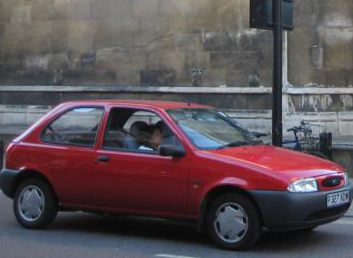

In [17]:
dp.lz[(dp["target"] & dp["correlate"]) == 1]["object_image"][2]

## Induce correlation
Let's induce an artificial correlation between cars and the color red.

In [18]:
from domino.evaluate.linear import induce_correlation

In [33]:
indices = induce_correlation(
    dp, 
    corr=0.8, 
    mu_a=0.05,
    mu_b=0.05,
    attr_a="target", 
    attr_b="correlate", 
    n=2e4
)
dataset_dp = dp.lz[indices]

In [34]:
from scipy.stats import pearsonr
pearsonr(dataset_dp["target"], dataset_dp["correlate"])

(0.7998092834663161, 0.0)

## Train a Model
Train a model on this subsampled dataset

In [35]:
from domino.utils import split_dp

In [36]:
dataset_dp = split_dp(dataset_dp, split_on="image_id")

In [ ]:
import terra 
from domino.vision import train
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

dataset_dp["input"] = dataset_dp["object_image"].to_lambda(preprocessing)

@terra.Task.make_task
def train_vg(dp, run_dir: str = None):

    model = train(
        config={"pretrained": False},
        dp=dp,
        input_column="input",
        id_column="object_id",
        target_column="target",
        ckpt_monitor="valid_auroc",
        batch_size=128, 
        run_dir=run_dir,
        val_check_interval=10,
        num_workers=6
    )
    return model
train_vg(dp=dataset_dp)

In [38]:
model = train_vg.get_artifacts("best_chkpt", 4513)["model"]

## Score model
Let's score the model and evaluate on subgroups.

In [39]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=dataset_dp.lz[dataset_dp["split"] == "test"], 
    input_column="input",
    batch_size=128
)

In [40]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]

In [88]:
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp["correlate"], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] == score_dp["correlate"]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp["correlate"], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] != score_dp["correlate"]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp["correlate"], curr_dp["prob"])
))

Overall AUROC: 0.9370451427934228
AUROC where correlation holds: 0.9547952982034328
AUROC where correlation does not hold: 0.6582491582491583


In [118]:
len(score_dp.lz[score_dp["target"] == score_dp["correlate"]])

4019

## Embed in CLIP space to recover spurious correlate

In [44]:
from domino.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="object_image")

In [52]:
from domino.clip import embed_words
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(4508).load()
words_dp = words_dp.lz[:int(1e4)]

In [135]:
dp = score_dp
attr_emb = dp.lz[(dp["prob"] > 0.7).numpy()]["emb"].data.numpy().mean(axis=0)
ref_emb = dp[dp["target"] == 1]["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
dp = dp.lz[(-scores).argsort()[:20]]

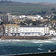

In [136]:
dp[0]["object_image"]

In [109]:
dp.lz[(dp["prob"] > 0.5).numpy() != dp["target"].data]['target'].mean()

0.6585365853658537

In [110]:
dp["target"].mean()

0.04598825831702544

In [61]:
from meerkat.nn import EmbeddingColumn
umap = EmbeddingColumn(score_dp["emb"]).umap().embeddings

In [66]:
score_dp["umap_0"], score_dp["umap_1"] = umap[:, 0], umap[:, 1]

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

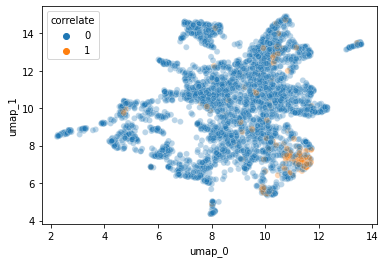

In [75]:
import seaborn as sns 
plot_df = score_dp[["umap_0", "umap_1", "correlate", "target"]].to_pandas()

sns.scatterplot(data=plot_df, x="umap_0", y="umap_1", hue="correlate", alpha=0.3)

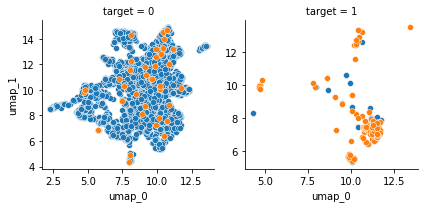

In [81]:
g = sns.FacetGrid(plot_df, col="target", hue="correlate", sharex=False, sharey=False)
g.map(sns.scatterplot, "umap_0", "umap_1")

In [134]:
words_dp

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,the,151983633,0,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
1,the,151983633,1,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
2,of,71874676,2,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
3,of,71874676,3,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
4,and,62210193,4,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
...,...,...,...,...,...
9995,halves,6523,9995,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9996,chemotherapy,6521,9996,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9997,sizable,6519,9997,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9998,shutout,6516,9998,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
